In [26]:
# Import packages (will need to change java environment code)
import pandas as pd
import numpy as np
import json
import os
import pyterrier as pt
from pyterrier.measures import *
import matplotlib.pyplot as plt
import seaborn as sns
os.environ["JAVA_HOME"] = "/home/rickmart/.conda/envs/terrier"
os.environ["JVM_PATH"] = "/home/rickmart/.conda/envs/terrier/lib/jvm/lib/server/libjvm.so"
os.environ["PATH"] = f"/home/rickmart/.conda/envs/terrier/bin:" + os.environ["PATH"]
if not pt.started():
    pt.init()

/tmp/ipykernel_3081752/3852199472.py:13: DeprecationWarning: Call to deprecated function (or staticmethod) started. (use pt.java.started() instead) -- Deprecated since version 0.11.0.
  if not pt.started():


In [27]:
# read in 50,000 rows of recipe data
df = pd.read_json("project_data.json", lines=True)

In [28]:
# rename columns for pyterrier
corpus = df.rename(columns={'docid': 'docno', 'full_doc': 'text'})
corpus['docno'] = corpus['docno'].astype(str)

In [29]:
# create and save the index: only run the first time
# indexer = pt.IterDictIndexer("./terrier_index")
# index_ref = indexer.index(corpus.to_dict(orient='records'))

In [30]:
index_ref = pt.IndexRef.of("./terrier_index/data.properties")

In [31]:
index = pt.IndexFactory.of(index_ref)

In [32]:
# Create the models
bm25 = pt.BatchRetrieve(index_ref, wmodel="BM25")
tfidf = pt.BatchRetrieve(index_ref, wmodel="TF_IDF")
pivoted = pt.BatchRetrieve(index_ref, wmodel="TF_IDF", controls={"c":0.25})
dirichlet = pt.BatchRetrieve(index_ref, wmodel="DirichletLM")

/tmp/ipykernel_3081752/1274612214.py:2: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25 = pt.BatchRetrieve(index_ref, wmodel="BM25")
/tmp/ipykernel_3081752/1274612214.py:3: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  tfidf = pt.BatchRetrieve(index_ref, wmodel="TF_IDF")
/tmp/ipykernel_3081752/1274612214.py:4: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  pivoted = pt.BatchRetrieve(index_ref, wmodel="TF_IDF", controls={"c":0.25})
/tmp/ipykernel_3081752/1274612214.py:5: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  dirichlet = pt.BatchRetrieve(index_ref, wmodel="DirichletLM")


In [33]:
# Create the naive model: longest docs
class LongestDocsRetriever(pt.Transformer):
    def __init__(self, corpus_df):
        super().__init__()
        self.docs = corpus_df[["docno", "text"]].copy()
        self.docs["length"] = self.docs["text"].str.len()
        self.docs = self.docs.sort_values("length", ascending=False)

    def transform(self, queries_df):
        results = []
        for _, q in queries_df.iterrows():
            for rank, (docno, row) in enumerate(self.docs.head(50).iterrows()):
                results.append({
                    "qid": q["qid"],
                    "query": q["query"],
                    "docno": row["docno"],
                    "score": float(row["length"]),
                    "rank": rank
                })
        return pd.DataFrame(results)

In [34]:
longest = LongestDocsRetriever(corpus)

In [35]:
# Load in the csv contains the 40 queries
queries = pd.read_csv("SI_650_project_queries.csv")

In [36]:
# Get the top results for each model and each query so they can be labeled
results_tfidf = tfidf.transform(queries).groupby('qid').head(10)
results_bm25 = bm25.transform(queries).groupby('qid').head(20)
results_piv = pivoted.transform(queries).groupby('qid').head(30)
results_dirichlet = dirichlet.transform(queries).groupby('qid').head(22)
results_longest = longest.transform(queries).groupby('qid').head(17)


In [37]:
# Combine the results from each of the models and filter down to 50 results per query
combined = pd.concat([
    results_tfidf.assign(model="TF-IDF"),
    results_bm25.assign(model="BM25"),
    results_piv.assign(model="piv_norm"),
    results_dirichlet.assign(model="dirichlet"),
    results_longest.assign(model="LongestDocs")
], ignore_index=True)

combined_unique = combined.drop_duplicates(subset=["qid", "docno"]).groupby("qid").head(50)

In [38]:
# modify the data so it is ready for labeling
label_df = combined_unique.merge(corpus, on="docno", how="left")
label_df_rand = label_df.sample(frac=1, random_state=42).reset_index(drop=True)
label_df_filtered = label_df_rand[["qid","query","docno","title","text"]]

In [39]:
# save all of the data to CSVs to be labeled
for qid, group in label_df_filtered.groupby("qid"):
    filename = os.path.join("label_data", f"label_data_q{qid}.csv")
    group.to_csv(filename, index=False)

In [40]:
#LABEL all data

In [41]:
#Load in labeled data

In [42]:
file_names = [f"SI650_relevance_data_labeling - label_data_q{i}.csv" for i in range(1, 41)]

In [43]:
dfs = []

for file in file_names:
    df = pd.read_csv( "labeled_relevance_data/" + file)
    qid = int(file.split("_q")[1].split(".")[0])
    df["qid_file"] = qid
    dfs.append(df)

In [44]:
combined_df = pd.concat(dfs, ignore_index=True)

In [45]:
# format the relevance data
qrels = combined_df[["qid","docno","rel"]]
qrels = qrels.rename(columns={"rel": "label"})
qrels["qid"] = qrels["qid"].astype(str)
qrels["docno"] = qrels["docno"].astype(str)

In [46]:
# Get the runs for each of the models
test_tfidf = tfidf.transform(queries)
test_bm25 = bm25.transform(queries)
test_piv = pivoted.transform(queries)
test_dirichlet = dirichlet.transform(queries)
test_longest = longest.transform(queries)

In [47]:
runs = [test_tfidf, test_bm25,test_piv,test_dirichlet,test_longest]
model_names = ["TF-IDF","BM25","Pivoted Normalization","Dirichlet","Longest Docs (naive)"]

In [55]:
# Retrieve the MAP and NDCG@10 scores for each of the 5 models
results = pt.Experiment(runs, queries, qrels, ["map", nDCG@10], model_names)

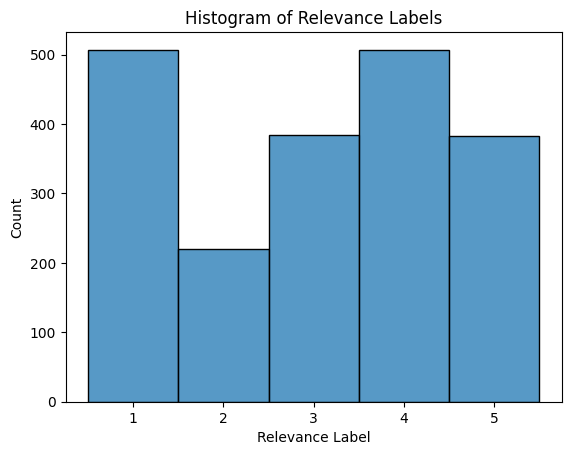

In [49]:
sns.histplot(data=combined_df, x="rel", bins=range(int(combined_df['rel'].min()), int(combined_df['rel'].max())+2), discrete=True)
plt.xlabel("Relevance Label")
plt.ylabel("Count")
plt.title("Histogram of Relevance Labels")
plt.show()

In [57]:
l2r_row = {"name": "L2R", "map": 0.7000032912166254, "nDCG@10": 0.8404339803809483}
results = pd.concat([results,pd.DataFrame([l2r_row])], ignore_index=True)

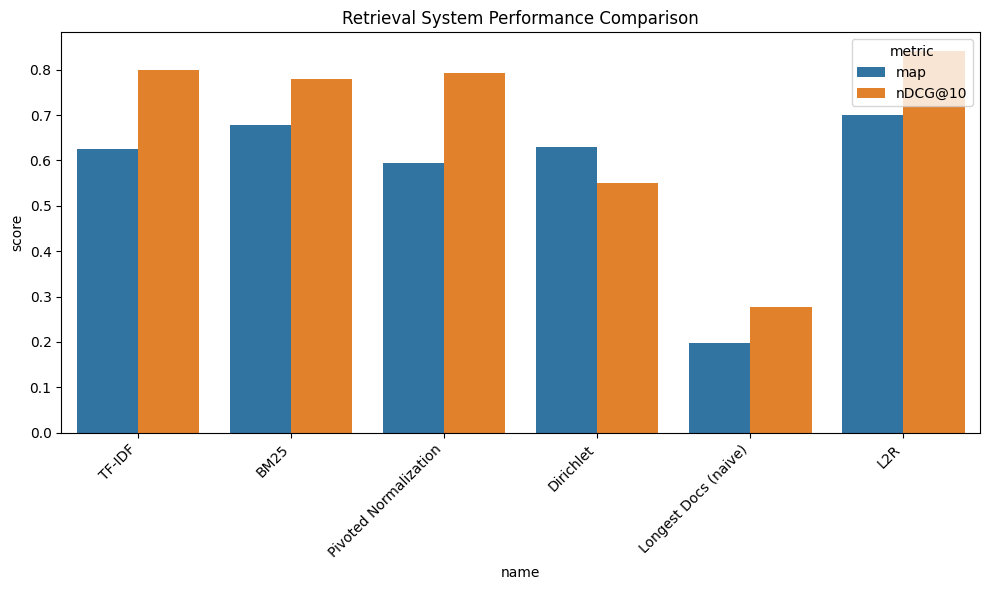

In [60]:
df_melt = results.melt(id_vars="name", value_vars=["map", "nDCG@10"],
                  var_name="metric", value_name="score")

plt.figure(figsize=(10,6))
sns.barplot(data=df_melt, x="name", y="score", hue="metric")
plt.xticks(rotation=45, ha='right')
plt.title("Retrieval System Performance Comparison")
plt.tight_layout()
plt.show()